# Transformer Encoder for Tweet Hatespeech Classification

Implementation adapted from <a href="https://towardsdatascience.com/text-classification-with-transformer-encoders-1dcaa50dabae"> Ruben Winastwan's model</a> for classifying emails as spam or not spam.

The transformer architecture as described in "Attention is All You Need" (Vaswani et al.) are used for text generation or translation tasks, and use both an encoder and decoder. 

The encoder portion of the architecture can be used by itself for classification tasks. This implementation uses this idea to classify text as containing hatespeech/offensive language or not.

### Import Libraries, Load the dataset

In [22]:
import math
import torch
import torch.nn as nn
import torchtext
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from tqdm import tqdm
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [23]:
DATA_PATH = "data/labeled_data.csv"

full_tweets_df = pd.read_csv(DATA_PATH)
full_tweets_df=full_tweets_df[["class","tweet"]]

### CLASS 1 : Contains no hatespeech  language or hatespeech
### CLASS 0 : Contains offensive language / hatespeech
full_tweets_df["class"] = full_tweets_df["class"].replace({2: 1, 0: 0, 1: 1})

np.random.seed(42)

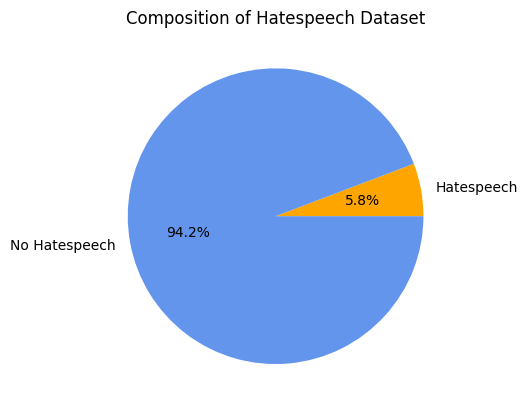

In [24]:
labels = 'Hatespeech', 'No Hatespeech'


sizes = [full_tweets_df['class'].value_counts()[0], full_tweets_df['class'].value_counts()[1]]

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels,autopct='%1.1f%%',colors=['#8f2e8b', '#55a4ff'])
ax.set_title("Composition of Hatespeech Dataset")
plt.save_fig
plt.show()

## Undersampling

For our dataset, only about 6% of all entries fall into the hatespeech category. This is not great for us, because transformer models trained on this dataset never train and always label tweets as not containing hatespeech. In order to counteract this, we employ a method of undersampling. We randomly delete records from the "No Hatespeech" category. The goal is to increase the slice that the hatespeech tweets occupy, so that at least 10% of all the tweets are hatespeech tweets. This way, the model can actually train.

<a href="https://discuss.huggingface.co/t/how-can-i-use-class-weights-when-training/1067/9">source 1<a>

<a href="https://discuss.huggingface.co/t/how-to-give-equal-importance-of-all-labels-while-dealing-with-unbalanced-samples/14174"> source 2 </a>

class
1    23353
0     1430
Name: count, dtype: int64
class
1    13440
0     1430
Name: count, dtype: int64


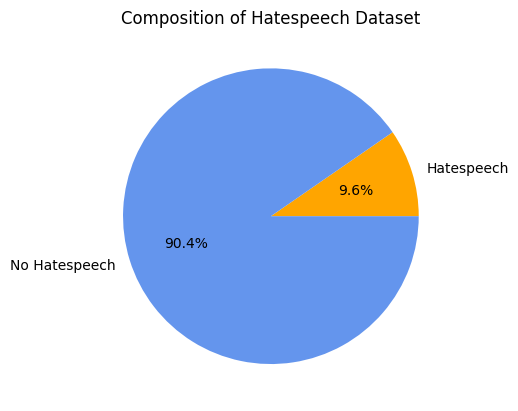

In [25]:
import random
# Calculate the number of rows for each class
class_counts = full_tweets_df['class'].value_counts()

print(class_counts)

total = class_counts[0] + class_counts[1]

difference = int(total*0.4)

# Identify the indices of the rows belonging to the majority class
majority_indices = full_tweets_df[full_tweets_df['class'] == 1].index.tolist()

# Randomly select indices from the majority indices to remove
indices_to_remove = random.sample(majority_indices, difference)

# Remove the selected indices from the DataFrame
tweets_df = full_tweets_df.drop(indices_to_remove)

labels = 'Hatespeech', 'No Hatespeech'


sizes = [tweets_df['class'].value_counts()[0], tweets_df['class'].value_counts()[1]]

class_counts = tweets_df['class'].value_counts()

print(class_counts)

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels,autopct='%1.1f%%',colors=['orange', 'cornflowerblue'])
ax.set_title("Composition of Hatespeech Dataset")
plt.show()

## Investigating How Accurate Filtering By Insults is

Why do we need a machine learning model to look for hatespeech and offensive language?
Here I will try the common strategy of simply flagging words known to be offensive by using a dataset of offensive words found on this github repository : 

In [26]:
import requests
import csv

CSV_URL="https://raw.githubusercontent.com/surge-ai/profanity/main/profanity_en.csv"

with requests.Session() as s:
    download = s.get(CSV_URL)

    decoded_content = download.content.decode('utf-8')

    cr = csv.reader(decoded_content.splitlines(), delimiter=',')
    my_list = list(cr)
insults_df=pd.DataFrame(my_list)
insults_df.columns = insults_df.iloc[0]
insults_df=insults_df[["text","canonical_form_1","category_1","severity_description"]]

tweets_df['tweet'] = tweets_df['tweet'].str.lower()
insults_df['text'] = insults_df['text'].str.lower()

severe_insults_df = insults_df[(insults_df["severity_description"] == "Severe")];

In [27]:
tweets_df['tweet'] = tweets_df['tweet'].str.lower()
insults_df['text'] = insults_df['text'].str.lower()

def find_first_insult(tweet, df):
    words = tweet.split(" ")
    # print(tweet)
    insults = []
    for word in words:
        word = word.strip()
        if df['text'].isin([word]).any():
            insults.append(word)
    if len(insults) > 0:
        return insults
    else:
        return None
    
def contains_insult(tweet, df):
    words = tweet.split(" ")
    for word in words:
        word = word.strip()
        if df['text'].isin([word]).any():
            return True
    return False


# find insults in each tweet
tweets_df['contains_insult'] = tweets_df['tweet'].apply(lambda x: find_first_insult(x,insults_df))
tweets_df['contains_severe_insult'] = tweets_df['tweet'].apply(lambda x: contains_insult(x,severe_insults_df))

# Filter tweets containing insults from the insult dataset
hatespeech_tweets = tweets_df[tweets_df['class'] == 0]
no_hatespeech_tweets = tweets_df[tweets_df['class'] == 1];

In [28]:

insult_hatespeech_categories = {}
insult_no_hatespeech_categories = {}

def category_of_insults(insult_list, df, hatespeech = True):
    global insult_hatespeech_categories
    global insult_no_hatespeech_categories
    categories = []
    if insult_list == None:
        return None
    for insult in insult_list:
        if not df['text'].isin([insult]).any():
            continue
        row = df[df['text'].str.contains(insult)].iloc[0]['category_1']
        category = row.strip()
        if category == 'category_1':
            continue
        categories.append(category)
        if hatespeech:
            if category in insult_hatespeech_categories:
                insult_hatespeech_categories[category] += 1
            else:
                insult_hatespeech_categories[category] = 1
        else:
            if category in insult_no_hatespeech_categories:
                insult_no_hatespeech_categories[category] += 1
            else:
                insult_no_hatespeech_categories[category] = 1
    if len(categories) == 0:
        categories = None
    return categories

hatespeech_tweets['category'] = hatespeech_tweets['contains_insult'].apply(lambda x: category_of_insults(x,severe_insults_df, True))
no_hatespeech_tweets['category'] = no_hatespeech_tweets['contains_insult'].apply(lambda x: category_of_insults(x,severe_insults_df, False));


/var/folders/56/lnrgwj295yq6l00hqdbfzfmr0000gn/T/ipykernel_20918/1651706291.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hatespeech_tweets['category'] = hatespeech_tweets['contains_insult'].apply(lambda x: category_of_insults(x,severe_insults_df, True))
/var/folders/56/lnrgwj295yq6l00hqdbfzfmr0000gn/T/ipykernel_20918/1651706291.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_hatespeech_tweets['category'] = no_hatespeech_tweets['contains_insult'].apply(lambda x: category_of_insults(x,severe_i

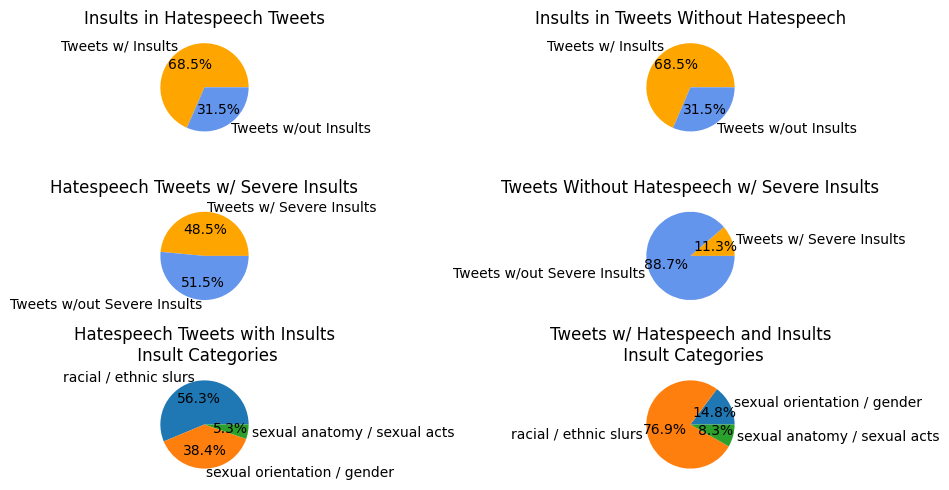

In [29]:
# Count the number of tweets with and without insults for hatespeech and no_hatespeech tweets
no_insults_hatespeech_count = hatespeech_tweets['contains_insult'].isna().sum()
no_insults_no_hatespeech_count = no_hatespeech_tweets['contains_insult'].isna().sum()

# Count the number of tweets without severe insults for hatespeech and no_hatespeech tweets
severe_hatespeech_count = (hatespeech_tweets['contains_severe_insult'] == True).sum()
no_severe_hatespeech_count = (hatespeech_tweets['contains_severe_insult'] == False).sum()

severe_no_hatespeech_count = (no_hatespeech_tweets['contains_severe_insult'] == True).sum()
no_severe_no_hatespeech_count = (no_hatespeech_tweets['contains_severe_insult'] == False).sum()

# Plotting pie charts
fig, axs = plt.subplots(3, 2, figsize=(10, 5))

# Pie chart for offensive tweets
axs[0][0].pie([hatespeech_tweets['contains_insult'].size - no_insults_hatespeech_count, no_insults_hatespeech_count], 
       labels=['Tweets w/ Insults', 'Tweets w/out Insults'],autopct='%1.1f%%',colors=['orange', 'cornflowerblue'])
axs[0][0].set_title('Insults in Hatespeech Tweets')

# Pie chart for no_hatespeech tweets
axs[0][1].pie([no_hatespeech_tweets['contains_insult'].size - no_insults_no_hatespeech_count, no_insults_no_hatespeech_count], 
       labels=['Tweets w/ Insults', 'Tweets w/out Insults'],autopct='%1.1f%%',colors=['orange', 'cornflowerblue'])
axs[0][1].set_title('Insults in Tweets Without Hatespeech')

axs[1][0].pie([severe_hatespeech_count, no_severe_hatespeech_count],
              labels=['Tweets w/ Severe Insults','Tweets w/out Severe Insults'],autopct='%1.1f%%',colors=['orange', 'cornflowerblue'])
axs[1][0].set_title('Hatespeech Tweets w/ Severe Insults')

axs[1][1].pie([severe_no_hatespeech_count, no_severe_no_hatespeech_count],
              labels=['Tweets w/ Severe Insults','Tweets w/out Severe Insults'],autopct='%1.1f%%',colors=['orange', 'cornflowerblue'])
axs[1][1].set_title('Tweets Without Hatespeech w/ Severe Insults')

axs[2][0].pie([x for x in insult_hatespeech_categories.values()],
              labels=[x for x in insult_hatespeech_categories.keys()], autopct='%1.1f%%')
axs[2][0].set_title('Hatespeech Tweets with Insults\n Insult Categories')

axs[2][1].pie([x for x in insult_no_hatespeech_categories.values()],
              labels=[x for x in insult_no_hatespeech_categories.keys()], autopct='%1.1f%%')
axs[2][1].set_title('Tweets w/ Hatespeech and Insults\n Insult Categories')

plt.tight_layout()
plt.show()

# Create pie chart

# Extract category labels and frequencies
# insult_hatespeech_categories
# insult_no_hatespeech_categories
categories_hatespeech_insults = list(insult_hatespeech_categories.keys())
frequencies_hatespeech_insults = list(insult_hatespeech_categories.values())

categories_no_hatespeech_insults = list(insult_no_hatespeech_categories.keys())
frequencies_no_hatespeech_insults = list(insult_no_hatespeech_categories.values())


### Flagging Occurances of Specific Slurs As a Strategy for Labeling Hatespeech

Simply flagging for offensive words or swears in tweets, ignoring the context they exist in, is a possible approach that we can take in order to identify tweets as containing hatespeech or not. But this approach may not be sufficient to accurately flag tweets. 

The same proportion of hatespeech tweets and normal tweets contain insults / offensive language, to a tenth of a percentage. This shows that by simply flagging tweets as hatespeech for containing insults in general, we would mislabel 31.6% of normal tweets as hatespeech, and mislabel 31.5% of hatespeech tweets as not containing hatespeech. We would mislabel normal tweets and hatespeech tweets at exactly the same rate.

For tweets that contain insults or strong language, both hatespeech and not hatespeech tweets have similar makeups in terms of the category of the insult. All three have racial / ethnic slurs, sexual orientation / gender, and sexual anatomy / sexual acts as their top three categories of insult, in that order. Although, hatespeech tweets that contain insults do contain slightly less racial/ethnic slurs than not hatespeech tweets that contain insults.

Although hatespeech tweets disproportionately contain slurs labeled as "severe" in comparison to normal tweets, almost half of all hatespeech tweets do not contain "severe" language. Additionally, 11.4% of normal tweets also contain this "severe" language. Flagging all severe language would surely result in a large proportion of normal tweets, not containing hatespeech, in being flagged as hatespeech. This could become problematic, especially if these specific terms are being used in the context of social justice. If we label all tweets containing severe language as hatespeech, over half of all hatespeech tweets will not be labeled correctly.

## Code to load Tweets DF alone

In [30]:
import random
DATA_PATH = "data/labeled_data.csv"

full_tweets_df = pd.read_csv(DATA_PATH)
full_tweets_df=full_tweets_df[["class","tweet"]]

### CLASS 1 : Contains no hatespeech  language or hatespeech
### CLASS 0 : Contains offensive language / hatespeech
full_tweets_df["class"] = full_tweets_df["class"].replace({2: 1, 0: 0, 1: 1})


np.random.seed(42)


### UNDERSAMPLING
class_counts = full_tweets_df['class'].value_counts()
total = class_counts[0] + class_counts[1]
difference = int(total*0.4)

# Identify the indices of the rows belonging to the majority class
majority_indices = full_tweets_df[full_tweets_df['class'] == 1].index.tolist()

# Randomly select indices from the majority indices to remove
indices_to_remove = random.sample(majority_indices, difference)

# Remove the selected indices from the DataFrame
tweets_df = full_tweets_df.drop(indices_to_remove)

tweets_df['tweet'] = tweets_df['tweet'].str.lower()



### Machine Learning May Improve Our Odds

We believe that we can improve upon this strategy of flagging hatespeech by, instead of searching for particular phrases and words, utilizing machine learning algorithms to label text as containing hatespeech or not. This would allow for models to take into consideration the context surrounding the usage of the terms and insults, and hopefully allow for a more effective algorithm.

In [31]:
import re

# print(tweets_df["tweet"].head(30))

# Function to remove HTML numerical representations
def remove_html_numerical(text):
    # pattern = r'(&#\d+;)|((RT)?@[\w_0-9]+:?)|(https?://[^\s"]*)|(^!+( rt)?)|(^ (rt))|(^\s*")|("$)'
    pattern = r'(&#\d+;)|((RT)?@[\w_0-9]+:?)|(https?://[^\s"]*)'
    return re.sub(pattern, '', text)

tweets_df['tweet'] = tweets_df['tweet'].apply(lambda x: remove_html_numerical(x))

df_train, df_test = train_test_split(tweets_df,test_size=0.2)


In [32]:

label2id = {'Hatespeech':0, 'No Hatespeech':1}
id2label = {0: 'Hatespeech', 1: 'No Hatespeech'}


## Tokenizer

Splits the text into tokens. This is a word-level tokenizer, each token represents one word.

In [33]:
tokenizer = get_tokenizer('basic_english')

Map tokens, i.e. words, to integer representation according to the vocabulary. Each word in dataset gets it's own unique integer mapping. <pad\> will be used to make sequences all the same length later on. <unk\>, the unknown keyword will represent words not in the vocabulary.

In [34]:
# Initialize training data iterator
class TextIter(torch.utils.data.Dataset):

  def __init__(self, input_data):
      self.text = input_data['tweet'].values.tolist()
  def __len__(self):
      return len(self.text)
  def __getitem__(self, idx):
      return self.text[idx]

# Build vocabulary
def yield_tokens(data_iter):
    for text in data_iter:
        yield tokenizer(text)

data_iter = TextIter(df_train)
vocab = build_vocab_from_iterator(yield_tokens(data_iter), specials=["<pad>", "<unk>"])
vocab.set_default_index(vocab["<unk>"])
print(vocab.get_stoi())


{'~a': 14629, '~&gt': 14628, 'zzzzzz': 14625, 'zulema': 14624, 'zuko': 14623, 'zucchini': 14622, 'zoomed': 14621, 'zoom': 14620, 'zookeeper*': 14619, 'zoo': 14618, 'zoned': 14616, 'zip-line': 14613, 'zion': 14611, 'zim': 14610, 'zigeuner': 14608, 'zetti': 14606, 'zerah': 14605, 'zegt': 14602, 'zee': 14601, 'zappa': 14598, 'zaken': 14597, 'zak': 14596, 'zactly': 14595, 'zach': 14593, 'z-ro': 14592, 'yyyyyeelllloooowwwwww': 14591, 'yuuuuuuuuuaaaaaaa': 14590, 'yute': 14589, 'yusa': 14588, 'yuhhhh': 14586, 'yrn': 14584, 'youuuuu': 14581, 'yourselves': 14580, 'yourselfyour': 14579, 'younnnnng': 14577, 'youll': 14574, 'youda': 14573, 'you&gt': 14571, 'yooo': 14568, 'yoo': 14567, 'yokohamas': 14566, 'yokocho': 14565, 'yoda': 14564, 'yll': 14562, 'yhe': 14560, 'yg': 14559, 'yells': 14555, 'yelln': 14554, 'yeezus': 14550, 'yearbook': 14547, 'yeaaah': 14546, 'yeaaaaahhhh': 14545, 'ycg': 14541, 'yassssssssss': 14538, 'yaselves': 14536, 'yardy': 14534, 'yardie': 14533, 'yank': 14529, 'yalls': 1452

## Embedding Layer

In [35]:
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab_size):
        super(Embeddings, self).__init__()
        self.emb = nn.Embedding(vocab_size, d_model)
        self.d_model = d_model

    def forward(self, x):
        return self.emb(x) * math.sqrt(self.d_model)

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, vocab_size=5000, dropout=0.1):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(vocab_size, d_model)
        position = torch.arange(0, vocab_size, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float()
            * (-math.log(10000.0) / d_model)
        )
  
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer("pe", pe)

    def forward(self, x):
        x = x + self.pe[:, : x.size(1), :]
        return self.dropout(x)
    

class SingleHeadAttention(nn.Module):
    def __init__(self, d_model, d_head_size):
        super().__init__()
        self.lin_key = nn.Linear(d_model, d_head_size, bias=False)
        self.lin_query = nn.Linear(d_model, d_head_size, bias=False)
        self.lin_value = nn.Linear(d_model, d_head_size, bias=False)
        self.d_model = d_model

    def forward(self, x):
        query = self.lin_query(x)
        key = self.lin_key(x)
        value = self.lin_value(x)

        scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(self.d_model)
        p_attn = scores.softmax(dim=-1)
        x = torch.matmul(p_attn, value)

        return x
    
class MultiHeadAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        super().__init__()
        assert d_model % h == 0
        d_k = d_model // h
        self.multi_head = nn.ModuleList([SingleHeadAttention(d_model, d_k) for _ in range(h)])
        self.lin_agg = nn.Linear(d_model, d_model)

    def forward(self, x):
        x = torch.cat([head(x) for head in self.multi_head], dim=-1)
        return self.lin_agg(x)

class LayerNorm(nn.Module):
    def __init__(self, d_model, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(d_model))
        self.b_2 = nn.Parameter(torch.zeros(d_model))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

class ResidualConnection(nn.Module):
    def __init__(self, d_model, dropout=0.1):
        super().__init__()
        self.norm = LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x1, x2):
        return self.dropout(self.norm(x1 + x2))



In [36]:
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super().__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(self.w_1(x).relu()))



## Single Encoder

In [37]:
class SingleEncoder(nn.Module):
    def __init__(self, d_model, self_attn, feed_forward, dropout):
        super().__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.res_1 = ResidualConnection(d_model, dropout)
        self.res_2 = ResidualConnection(d_model, dropout)

        self.d_model = d_model

    def forward(self, x):
        x_attn = self.self_attn(x)
        x_res_1 = self.res_1(x, x_attn)
        x_ff = self.feed_forward(x_res_1)
        x_res_2 = self.res_2(x_res_1, x_ff)

        return x_res_2

## BERT-base model (12 stacks of Transformer encoders)

In [38]:
class EncoderBlocks(nn.Module):
    def __init__(self, layer, N):
        super().__init__()
        self.layers = nn.ModuleList([layer for _ in range(N)])
        self.norm = LayerNorm(layer.d_model)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return self.norm(x)

## Defining Our Model

In [39]:
class TransformerEncoderModel(nn.Module):
    def __init__(self, vocab_size, d_model, nhead, d_ff, N,
                dropout=0.1):
        super().__init__()
        assert d_model % nhead == 0, "nheads must divide evenly into d_model"

        self.emb = Embeddings(d_model, vocab_size)
        self.pos_encoder = PositionalEncoding(d_model=d_model, vocab_size=vocab_size)

        attn = MultiHeadAttention(nhead, d_model)
        ff = FeedForward(d_model, d_ff, dropout)
        self.transformer_encoder = EncoderBlocks(SingleEncoder(d_model, attn, ff, dropout), N)
        self.classifier = nn.Linear(d_model, 2)
        self.d_model = d_model

    def forward(self, x):
        x = self.emb(x) * math.sqrt(self.d_model)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = x.mean(dim=1)
        x = self.classifier(x)
        return x

In [40]:
class TextDataset(torch.utils.data.Dataset):

  def __init__(self, input_data):        
      self.text = input_data['tweet'].values.tolist()
      self.label = input_data['class'].values.tolist()

  def __len__(self):
      return len(self.label)
    
  def get_sequence_token(self, idx):
      sequence = [vocab[word] for word in tokenizer(self.text[idx])]
      len_seq = len(sequence)
      return sequence, len_seq
  
  def get_labels(self, idx):
      return self.label[idx]

  def __getitem__(self, idx):
      sequence, len_seq = self.get_sequence_token(idx)
      label = self.get_labels(idx)
      return sequence, label, len_seq

def collate_fn(batch):
  
    sequences, labels, lengths = zip(*batch)
    max_len = max(lengths)
    
    for i in range(len(batch)):
        if len(sequences[i]) != max_len:
          for j in range(len(sequences[i]),max_len):
            sequences[i].append(0)

    return torch.tensor(sequences, dtype=torch.long), torch.tensor(labels, dtype=torch.long)


## Training Loop

In [121]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


def train(model, dataset, test_dataset, epochs, lr, bs):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam((p for p in model.parameters() 
      if p.requires_grad), lr=lr)
    train_dataset = TextDataset(dataset)
    train_dataloader = DataLoader(train_dataset, num_workers=0, batch_size=bs, collate_fn=collate_fn, shuffle=True)
    train_accuracies = []
    train_losses = []
    test_accs = []
    test_losses = []
    # Training loop
    for epoch in range(epochs):
        all_preds = []
        all_labels = []
        
        total_loss_train = 0
        total_acc_train = 0   
        for train_sequence, train_label in tqdm(train_dataloader):
            
            # Model prediction
            predictions = model(train_sequence.to(device))
            labels = train_label.to(device)
            loss = criterion(predictions, labels)

            all_preds += predictions.tolist()
            all_labels += labels.tolist()
            
            # Calculate accuracy and loss per batch
            correct = predictions.argmax(axis=1) == labels
            # acc = correct.sum().item() / correct.size(0)
            # total_acc_train += acc
            total_loss_train += loss.item()

            # Backprop
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
            optimizer.step()
        
        all_preds = np.argmax(np.array(all_preds), axis=1)
        total_correct = np.sum(all_preds == np.array(all_labels))#.sum()#.item()
        # accuracies = total_correct/len(dataset)
        # print(classification_report(dataset['class'], all_preds))

        train_accuracies.append(total_correct / len(train_dataset))
        train_losses.append(total_loss_train / len(train_dataset))

        test_loss, test_acc = eval_test_loss(model, test_dataset, bs, epoch, epochs)
        test_losses.append(test_loss)
        test_accs.append(test_acc)
        print(f'Epochs: {epoch + 1} | Loss: {total_loss_train / len(train_dataset): .3f} | Accuracy: {total_correct / len(train_dataset): .3f} | Test Loss: {test_loss[-1]: .3f} | Test Accuracy: {test_acc: .3f}')
        
    return train_losses, train_accuracies, test_losses, test_accs


def eval_test_loss(model, dataset, bs, epoch, epochs):

    criterion = nn.CrossEntropyLoss()
    test_dataset = TextDataset(dataset)
    test_dataloader = DataLoader(test_dataset, num_workers=0, batch_size=bs, collate_fn=collate_fn, shuffle=False)
    test_accuracies = []
    test_losses = []
    # Training loop
    total_loss_test = 0
    total_acc_test = 0   
    all_preds = []
    all_labels = []
    for test_sequence, test_label in tqdm(test_dataloader):
        # Model prediction
        predictions = model(test_sequence.to(device))
        labels = test_label.to(device)
        loss = criterion(predictions, labels)
        
        # Calculate accuracy and loss per batch
        # total_correct = predictions.argmax(axis=1) == labels
        # acc = correct.sum()#.item() / correct.size(0)
        all_preds += predictions.tolist()
        all_labels += labels.tolist()
        # total_acc_test += total_correct
        total_loss_test += loss.item()
    all_preds = np.argmax(np.array(all_preds), axis=1)
    total_correct = np.sum(all_preds == np.array(all_labels))#.sum()#.item()
    test_accuracies = total_correct/len(test_dataset)
    if epoch == epochs-1:
        print(classification_report(dataset['class'], all_preds))
        cm = confusion_matrix(dataset['class'], all_preds)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                    display_labels=["Hatespeech","No Hatespeech"])
        disp.plot()
        plt.show()


    test_losses.append(total_loss_test / len(test_dataset))

    # print(f'Accuracy {total_correct/len(test_dataset)}, total correct predictions : {total_correct}')
    # if len(test_accuracies) == 1:
    #     test_accuracies = test_accuracies[0]
    # if len(test_losses) == 1:
    #     test_losses = test_losses[0]
        # test_accuracies = total_acc_test
        # test_losses = total_loss_test / len(test_dataset)
    # print(f'Test Loss: {total_loss_test / len(test_dataset)} | Accuracy: {total_acc_test / len(test_dataset)}')
    return test_losses, test_accuracies

  0%|          | 1/744 [00:00<01:19,  9.33it/s]

100%|██████████| 186/186 [00:05<00:00, 32.70it/s]


Epochs: 1 | Loss:  0.019 | Accuracy:  0.903 | Test Loss:  0.017 | Test Accuracy:  0.911


100%|██████████| 186/186 [00:06<00:00, 29.59it/s]


Epochs: 2 | Loss:  0.017 | Accuracy:  0.906 | Test Loss:  0.018 | Test Accuracy:  0.907


100%|██████████| 186/186 [00:06<00:00, 30.58it/s]


Epochs: 3 | Loss:  0.016 | Accuracy:  0.910 | Test Loss:  0.017 | Test Accuracy:  0.898


100%|██████████| 186/186 [00:06<00:00, 27.75it/s]


Epochs: 4 | Loss:  0.016 | Accuracy:  0.908 | Test Loss:  0.017 | Test Accuracy:  0.905


100%|██████████| 186/186 [00:06<00:00, 30.67it/s]


Epochs: 5 | Loss:  0.016 | Accuracy:  0.909 | Test Loss:  0.017 | Test Accuracy:  0.911


100%|██████████| 186/186 [00:06<00:00, 28.60it/s]


Epochs: 6 | Loss:  0.015 | Accuracy:  0.914 | Test Loss:  0.016 | Test Accuracy:  0.908


100%|██████████| 186/186 [00:07<00:00, 26.50it/s]


              precision    recall  f1-score   support

           0       0.61      0.21      0.31       282
           1       0.92      0.99      0.95      2692

    accuracy                           0.91      2974
   macro avg       0.77      0.60      0.63      2974
weighted avg       0.89      0.91      0.89      2974



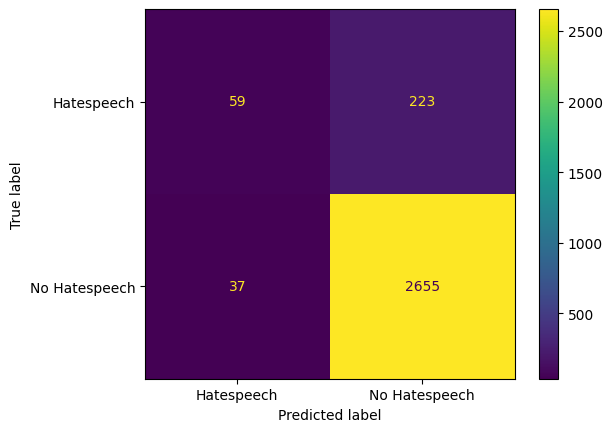

Epochs: 7 | Loss:  0.015 | Accuracy:  0.916 | Test Loss:  0.017 | Test Accuracy:  0.913
[0.01916216294478159, 0.017303087536581288, 0.016349875172142946, 0.016033184119307944, 0.015605415019038225, 0.014855216789011114, 0.014844250838114444] [[0.017285214995097296], [0.017920596628414158], [0.0174786317817962], [0.017261424447612108], [0.016677175493811952], [0.016481781662733026], [0.01716688271140944]]


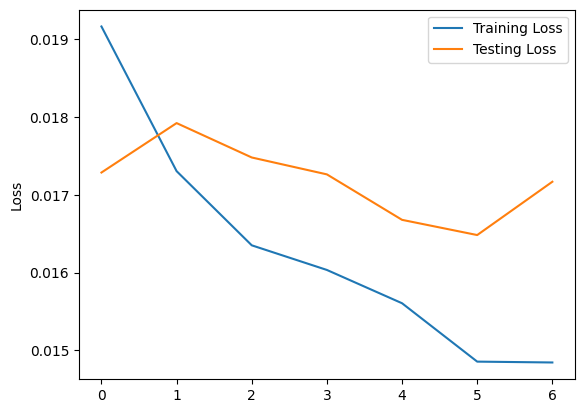

In [123]:
model = TransformerEncoderModel(len(vocab), d_model=300, nhead=4, d_ff=50, 
                                    N=6, dropout=0.1).to(device)

epochs = 7
lr = 1e-4
batch_size = 16

fold_train_losses, fold_train_accs, fold_test_losses, fold_test_accs  = train(model, df_train, df_test, epochs, lr, batch_size)

print(fold_train_losses, fold_test_losses)
plt.plot(fold_train_losses)
plt.plot(fold_test_losses)
plt.legend(['Training Loss', 'Testing Loss'])
plt.ylabel('Loss')
plt.show()

In [124]:
def predict(your_model, text):
  sequence = torch.tensor([vocab[word] for word in tokenizer(text)], dtype=torch.long).unsqueeze(0)
  output = your_model(sequence.to(device))
  prediction = output.argmax(axis=1).item()

  return prediction

Accuracy: 0.8920645595158037


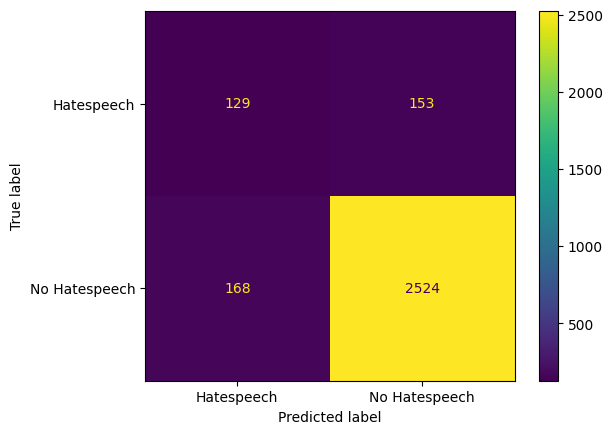

              precision    recall  f1-score   support

           0       0.43      0.46      0.45       282
           1       0.94      0.94      0.94      2692

    accuracy                           0.89      2974
   macro avg       0.69      0.70      0.69      2974
weighted avg       0.89      0.89      0.89      2974



In [54]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
correct = 0
incorrect = 0
predictions = []
for i in range(len(df_test)):

    text =  df_test['tweet'].iloc[i] #balanced_df['tweet'].values.tolist()[idx]
    gt = df_test['class'].iloc[i] #balanced_df['class'].values.tolist()[idx]
    prediction = predict(model, df_test['tweet'].iloc[i])
    predictions.append(prediction)

    if prediction == gt:
        correct += 1
    else:
        incorrect += 1

print("Accuracy:",correct/ (incorrect + correct))
cm = confusion_matrix(df_test['class'], predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=["Hatespeech","No Hatespeech"])
disp.plot()
plt.show()
from sklearn.metrics import classification_report
print(classification_report(df_test['class'], predictions))

# Overtrained model
Batch size of 16, 10 epochs, learning rate of 2e-5

Below the model is trained, we see the training + testing loss over the epochs, and then a confusion matrix of the testing dataset is shown

100%|██████████| 186/186 [00:07<00:00, 26.39it/s]


Epochs: 1 | Loss:  0.020 | Accuracy:  0.056 | Test Loss:  0.019 | Test Accuracy:  0.057


100%|██████████| 186/186 [00:06<00:00, 27.52it/s]


Epochs: 2 | Loss:  0.018 | Accuracy:  0.057 | Test Loss:  0.018 | Test Accuracy:  0.057


100%|██████████| 186/186 [00:06<00:00, 30.35it/s]


Epochs: 3 | Loss:  0.018 | Accuracy:  0.057 | Test Loss:  0.018 | Test Accuracy:  0.057


100%|██████████| 186/186 [00:06<00:00, 28.15it/s]


Epochs: 4 | Loss:  0.017 | Accuracy:  0.057 | Test Loss:  0.018 | Test Accuracy:  0.057


100%|██████████| 186/186 [00:06<00:00, 28.73it/s]


Epochs: 5 | Loss:  0.017 | Accuracy:  0.057 | Test Loss:  0.017 | Test Accuracy:  0.057


100%|██████████| 186/186 [00:06<00:00, 27.08it/s]


Epochs: 6 | Loss:  0.017 | Accuracy:  0.057 | Test Loss:  0.017 | Test Accuracy:  0.057


100%|██████████| 186/186 [00:07<00:00, 26.26it/s]


Epochs: 7 | Loss:  0.016 | Accuracy:  0.057 | Test Loss:  0.017 | Test Accuracy:  0.057


100%|██████████| 186/186 [00:06<00:00, 27.60it/s]


Epochs: 8 | Loss:  0.016 | Accuracy:  0.057 | Test Loss:  0.017 | Test Accuracy:  0.057


100%|██████████| 186/186 [00:07<00:00, 25.96it/s]


Epochs: 9 | Loss:  0.016 | Accuracy:  0.057 | Test Loss:  0.017 | Test Accuracy:  0.056


100%|██████████| 186/186 [00:06<00:00, 26.73it/s]


Epochs: 10 | Loss:  0.016 | Accuracy:  0.057 | Test Loss:  0.017 | Test Accuracy:  0.057
[0.01982280437282782, 0.01803566806836313, 0.017631497363282445, 0.01719774532904717, 0.01677356792955829, 0.01651390654923646, 0.016440503960306222, 0.016277036314896572, 0.015876475441950377, 0.015620976717166838] [[0.018728688466985832], [0.017977699006092814], [0.017683095325638803], [0.017834191086558624], [0.017401984529525905], [0.017196664917354786], [0.01718486234215016], [0.017126571979541545], [0.017111591441104617], [0.017411966773066934]]


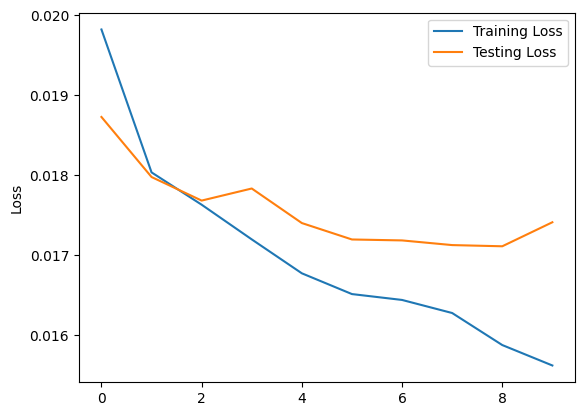

Accuracy: 0.8846671149966375


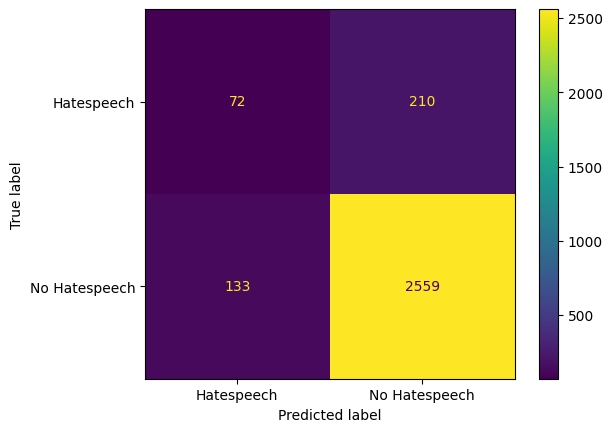

              precision    recall  f1-score   support

           0       0.35      0.26      0.30       282
           1       0.92      0.95      0.94      2692

    accuracy                           0.88      2974
   macro avg       0.64      0.60      0.62      2974
weighted avg       0.87      0.88      0.88      2974



In [57]:
model = TransformerEncoderModel(len(vocab), d_model=300, nhead=4, d_ff=50, 
                                    N=6, dropout=0.1).to(device)

epochs = 10
lr = 2e-5
batch_size = 16

fold_train_losses, fold_train_accs, fold_test_losses, fold_test_accs  = train(model, df_train, df_test, epochs, lr, batch_size)

print(fold_train_losses, fold_test_losses)
plt.plot(fold_train_losses)
plt.plot(fold_test_losses)
plt.legend(['Training Loss', 'Testing Loss'])
plt.ylabel('Loss')
plt.show()

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
correct = 0
incorrect = 0
predictions = []
for i in range(len(df_test)):

    text =  df_test['tweet'].iloc[i] #balanced_df['tweet'].values.tolist()[idx]
    gt = df_test['class'].iloc[i] #balanced_df['class'].values.tolist()[idx]
    prediction = predict(model, df_test['tweet'].iloc[i])
    predictions.append(prediction)

    if prediction == gt:
        correct += 1
    else:
        incorrect += 1

print("Accuracy:",correct/ (incorrect + correct))
cm = confusion_matrix(df_test['class'], predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=["Hatespeech","No Hatespeech"])
disp.plot()
plt.show()
from sklearn.metrics import classification_report
print(classification_report(df_test['class'], predictions))

# Attempt to correct for overtraining

Same parameters as overtrained model, reduced number of epochs to 6.

100%|██████████| 186/186 [00:07<00:00, 26.33it/s]


Epochs: 1 | Loss:  0.020 | Accuracy:  0.056 | Test Loss:  0.019 | Test Accuracy:  0.057


100%|██████████| 186/186 [00:07<00:00, 26.53it/s]


Epochs: 2 | Loss:  0.018 | Accuracy:  0.057 | Test Loss:  0.018 | Test Accuracy:  0.057


100%|██████████| 186/186 [00:06<00:00, 27.27it/s]


Epochs: 3 | Loss:  0.018 | Accuracy:  0.057 | Test Loss:  0.017 | Test Accuracy:  0.057


100%|██████████| 186/186 [00:06<00:00, 27.88it/s]


Epochs: 4 | Loss:  0.017 | Accuracy:  0.057 | Test Loss:  0.018 | Test Accuracy:  0.057


100%|██████████| 186/186 [00:06<00:00, 28.96it/s]


Epochs: 5 | Loss:  0.017 | Accuracy:  0.057 | Test Loss:  0.018 | Test Accuracy:  0.057


100%|██████████| 186/186 [00:06<00:00, 27.95it/s]


Epochs: 6 | Loss:  0.017 | Accuracy:  0.057 | Test Loss:  0.017 | Test Accuracy:  0.057
[0.019869168826066354, 0.018053943253727913, 0.017556463439949484, 0.017267669694656013, 0.016855239257825227, 0.01673095104148049] [[0.018749693765604983], [0.018069586335169682], [0.017362815440051815], [0.017649247649889226], [0.01773170549510186], [0.0171345774843417]]


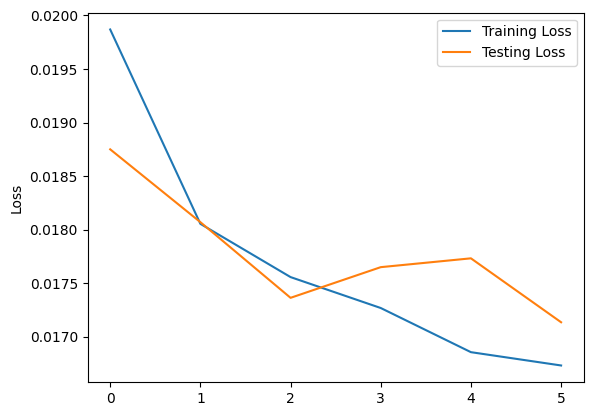

Accuracy: 0.8887020847343645


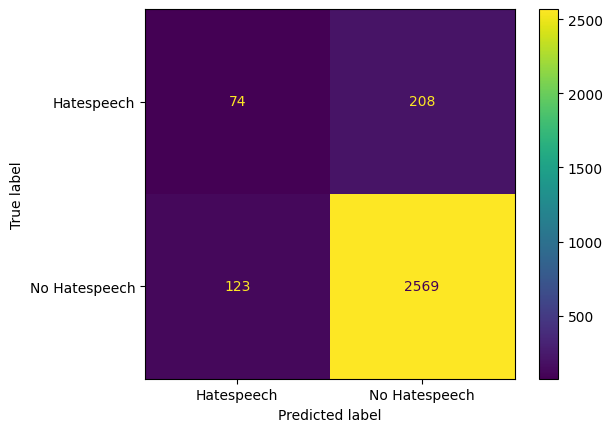

              precision    recall  f1-score   support

           0       0.38      0.26      0.31       282
           1       0.93      0.95      0.94      2692

    accuracy                           0.89      2974
   macro avg       0.65      0.61      0.62      2974
weighted avg       0.87      0.89      0.88      2974



In [72]:
model2 = TransformerEncoderModel(len(vocab), d_model=300, nhead=4, d_ff=50, 
                                    N=6, dropout=0.1).to(device)

epochs = 6
lr = 2e-5
batch_size = 16

fold_train_losses, fold_train_accs, fold_test_losses, fold_test_accs  = train(model2, df_train, df_test, epochs, lr, batch_size)

print(fold_train_losses, fold_test_losses)
plt.plot(fold_train_losses)
plt.plot(fold_test_losses)
plt.legend(['Training Loss', 'Testing Loss'])
plt.ylabel('Loss')
plt.show()

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
correct = 0
incorrect = 0
predictions = []
for i in range(len(df_test)):

    text =  df_test['tweet'].iloc[i] #balanced_df['tweet'].values.tolist()[idx]
    gt = df_test['class'].iloc[i] #balanced_df['class'].values.tolist()[idx]
    prediction = predict(model2, df_test['tweet'].iloc[i])
    predictions.append(prediction)

    if prediction == gt:
        correct += 1
    else:
        incorrect += 1

print("Accuracy:",correct/ (incorrect + correct))
cm = confusion_matrix(df_test['class'], predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=["Hatespeech","No Hatespeech"])
disp.plot()
plt.show()
from sklearn.metrics import classification_report
print(classification_report(df_test['class'], predictions))

# Confusion matrices for corrected, overtrained model

Confusion matrix for the model predicting labels for the testing dataset, and then the training dataset.

Accuracy: 0.8903833221250841 for testing dataset


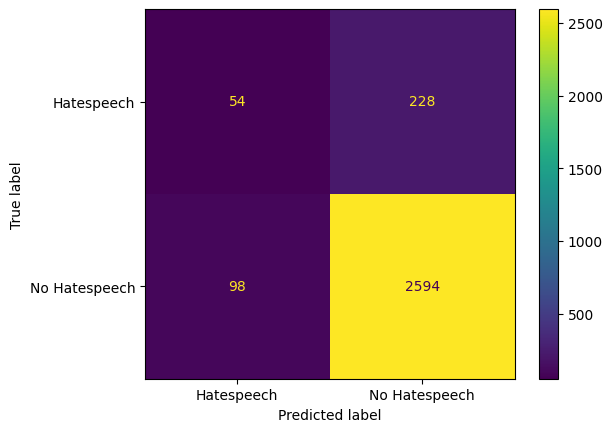

              precision    recall  f1-score   support

           0       0.36      0.19      0.25       282
           1       0.92      0.96      0.94      2692

    accuracy                           0.89      2974
   macro avg       0.64      0.58      0.59      2974
weighted avg       0.87      0.89      0.88      2974



/var/folders/56/lnrgwj295yq6l00hqdbfzfmr0000gn/T/ipykernel_20918/2956895512.py:72: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/ReduceOps.cpp:1760.)
  std = x.std(-1, keepdim=True)


Accuracy: 0.8979488903833222 for training dataset


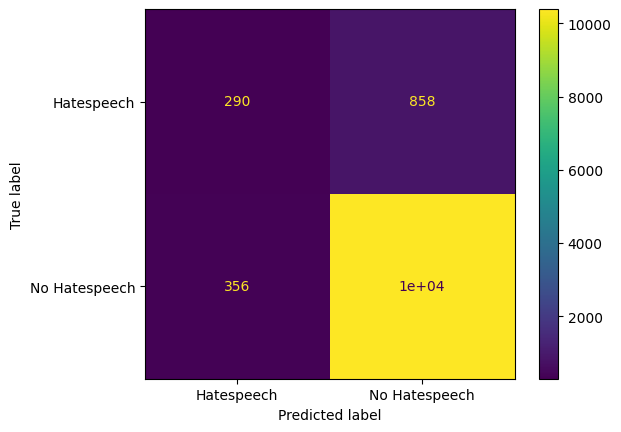

              precision    recall  f1-score   support

           0       0.45      0.25      0.32      1148
           1       0.92      0.97      0.94     10748

    accuracy                           0.90     11896
   macro avg       0.69      0.61      0.63     11896
weighted avg       0.88      0.90      0.88     11896



In [75]:
correct = 0
incorrect = 0
predictions = []
for i in range(len(df_test)):

    text =  df_test['tweet'].iloc[i] #balanced_df['tweet'].values.tolist()[idx]
    gt = df_test['class'].iloc[i] #balanced_df['class'].values.tolist()[idx]
    prediction = predict(model2, df_test['tweet'].iloc[i])
    predictions.append(prediction)

    if prediction == gt:
        correct += 1
    else:
        incorrect += 1

print("Accuracy:",correct/ (incorrect + correct), "for testing dataset")
cm = confusion_matrix(df_test['class'], predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=["Hatespeech","No Hatespeech"])
disp.plot()
plt.show()
from sklearn.metrics import classification_report
print(classification_report(df_test['class'], predictions))



correct = 0
incorrect = 0
predictions = []
for i in range(len(df_train)):

    text =  df_train['tweet'].iloc[i] #balanced_df['tweet'].values.tolist()[idx]
    gt = df_train['class'].iloc[i] #balanced_df['class'].values.tolist()[idx]
    prediction = predict(model2, df_train['tweet'].iloc[i])
    predictions.append(prediction)

    if prediction == gt:
        correct += 1
    else:
        incorrect += 1

print("Accuracy:",correct/ (incorrect + correct), "for training dataset")
cm = confusion_matrix(df_train['class'], predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=["Hatespeech","No Hatespeech"])
disp.plot()
plt.show()
from sklearn.metrics import classification_report
print(classification_report(df_train['class'], predictions))





In [78]:
print(df_test.describe())
print(df_train.describe())


             class
count  2974.000000
mean      0.905178
std       0.293018
min       0.000000
25%       1.000000
50%       1.000000
75%       1.000000
max       1.000000
              class
count  11896.000000
mean       0.903497
std        0.295292
min        0.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        1.000000


## Cross Validation

~~~~~~~~~~~~~~~~~~~~~~~~~~
Training for fold 1


  0%|          | 0/372 [00:00<?, ?it/s]

100%|██████████| 93/93 [00:06<00:00, 15.33it/s]


Epochs: 1 | Loss:  0.010 | Accuracy:  0.903 | Test Loss:  0.009 | Test Accuracy:  0.907


100%|██████████| 93/93 [00:06<00:00, 15.27it/s]


Epochs: 2 | Loss:  0.009 | Accuracy:  0.901 | Test Loss:  0.009 | Test Accuracy:  0.907


100%|██████████| 93/93 [00:06<00:00, 14.83it/s]


Epochs: 3 | Loss:  0.009 | Accuracy:  0.903 | Test Loss:  0.009 | Test Accuracy:  0.908


100%|██████████| 93/93 [00:06<00:00, 14.04it/s]


Epochs: 4 | Loss:  0.008 | Accuracy:  0.907 | Test Loss:  0.008 | Test Accuracy:  0.906


100%|██████████| 93/93 [00:05<00:00, 16.15it/s]


Epochs: 5 | Loss:  0.008 | Accuracy:  0.910 | Test Loss:  0.008 | Test Accuracy:  0.906


100%|██████████| 93/93 [00:06<00:00, 14.20it/s]


Epochs: 6 | Loss:  0.008 | Accuracy:  0.912 | Test Loss:  0.008 | Test Accuracy:  0.910


100%|██████████| 93/93 [00:06<00:00, 14.98it/s]


              precision    recall  f1-score   support

           0       0.49      0.21      0.29       277
           1       0.92      0.98      0.95      2697

    accuracy                           0.91      2974
   macro avg       0.71      0.59      0.62      2974
weighted avg       0.88      0.91      0.89      2974



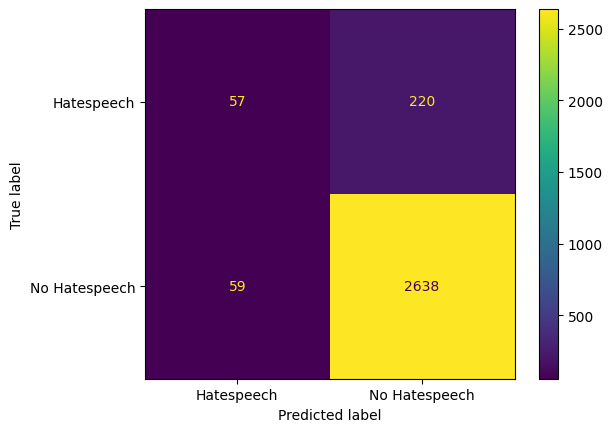

Epochs: 7 | Loss:  0.007 | Accuracy:  0.914 | Test Loss:  0.008 | Test Accuracy:  0.906
[0.009899178956696049, 0.009227435633780657, 0.008748311819990931, 0.00831341125896525, 0.008060289210832171, 0.0077439855097429155, 0.007461367197530175] [[0.009169707013383037], [0.00854623531415387], [0.0085808860429919], [0.008440950583533785], [0.008288708820478101], [0.008162638534514313], [0.00804285768722638]]


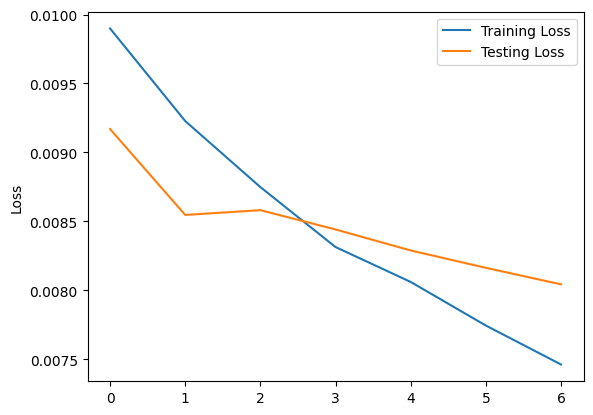

~~~~~~~~~~~~~~~~~~~~~~~~~~
Training for fold 2


100%|██████████| 93/93 [00:06<00:00, 15.03it/s]


Epochs: 1 | Loss:  0.010 | Accuracy:  0.903 | Test Loss:  0.009 | Test Accuracy:  0.902


100%|██████████| 93/93 [00:05<00:00, 15.57it/s]


Epochs: 2 | Loss:  0.009 | Accuracy:  0.905 | Test Loss:  0.008 | Test Accuracy:  0.910


100%|██████████| 93/93 [00:05<00:00, 15.62it/s]


Epochs: 3 | Loss:  0.009 | Accuracy:  0.906 | Test Loss:  0.008 | Test Accuracy:  0.911


100%|██████████| 93/93 [00:06<00:00, 14.74it/s]


Epochs: 4 | Loss:  0.008 | Accuracy:  0.910 | Test Loss:  0.008 | Test Accuracy:  0.909


100%|██████████| 93/93 [00:05<00:00, 16.08it/s]


Epochs: 5 | Loss:  0.008 | Accuracy:  0.912 | Test Loss:  0.008 | Test Accuracy:  0.914


100%|██████████| 93/93 [00:07<00:00, 12.64it/s]


Epochs: 6 | Loss:  0.008 | Accuracy:  0.911 | Test Loss:  0.009 | Test Accuracy:  0.912


100%|██████████| 93/93 [00:06<00:00, 14.49it/s]


              precision    recall  f1-score   support

           0       0.50      0.18      0.26       271
           1       0.92      0.98      0.95      2703

    accuracy                           0.91      2974
   macro avg       0.71      0.58      0.61      2974
weighted avg       0.88      0.91      0.89      2974



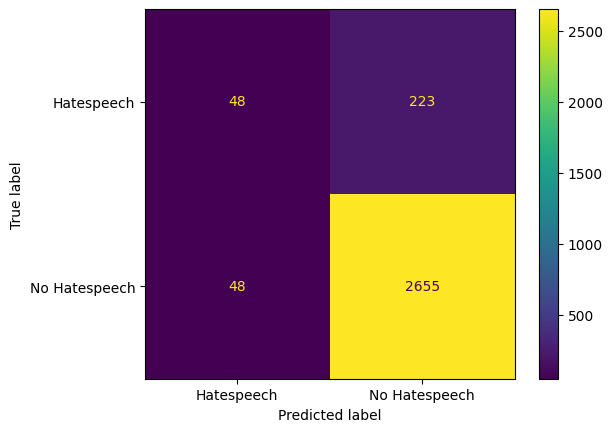

Epochs: 7 | Loss:  0.008 | Accuracy:  0.914 | Test Loss:  0.008 | Test Accuracy:  0.909
[0.00982997897372311, 0.009047011996067625, 0.008509840432644671, 0.00821183282204308, 0.008071384108960428, 0.00782208619157019, 0.007585860262721998] [[0.0090111423992798], [0.008281516448595256], [0.008123334596170302], [0.008247049366297462], [0.008036985150372412], [0.008634038545096088], [0.008003834439610665]]


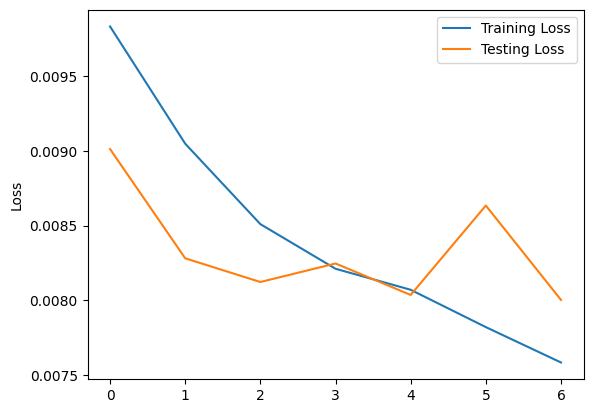

~~~~~~~~~~~~~~~~~~~~~~~~~~
Training for fold 3


100%|██████████| 93/93 [00:06<00:00, 14.88it/s]


Epochs: 1 | Loss:  0.010 | Accuracy:  0.900 | Test Loss:  0.009 | Test Accuracy:  0.903


100%|██████████| 93/93 [00:06<00:00, 13.63it/s]


Epochs: 2 | Loss:  0.009 | Accuracy:  0.902 | Test Loss:  0.009 | Test Accuracy:  0.902


100%|██████████| 93/93 [00:05<00:00, 15.92it/s]


Epochs: 3 | Loss:  0.009 | Accuracy:  0.906 | Test Loss:  0.009 | Test Accuracy:  0.908


100%|██████████| 93/93 [00:06<00:00, 14.42it/s]


Epochs: 4 | Loss:  0.008 | Accuracy:  0.904 | Test Loss:  0.008 | Test Accuracy:  0.907


100%|██████████| 93/93 [00:05<00:00, 15.96it/s]


Epochs: 5 | Loss:  0.008 | Accuracy:  0.910 | Test Loss:  0.008 | Test Accuracy:  0.905


100%|██████████| 93/93 [00:05<00:00, 16.45it/s]


Epochs: 6 | Loss:  0.008 | Accuracy:  0.911 | Test Loss:  0.008 | Test Accuracy:  0.910


100%|██████████| 93/93 [00:06<00:00, 14.23it/s]


              precision    recall  f1-score   support

           0       0.65      0.13      0.21       288
           1       0.91      0.99      0.95      2686

    accuracy                           0.91      2974
   macro avg       0.78      0.56      0.58      2974
weighted avg       0.89      0.91      0.88      2974



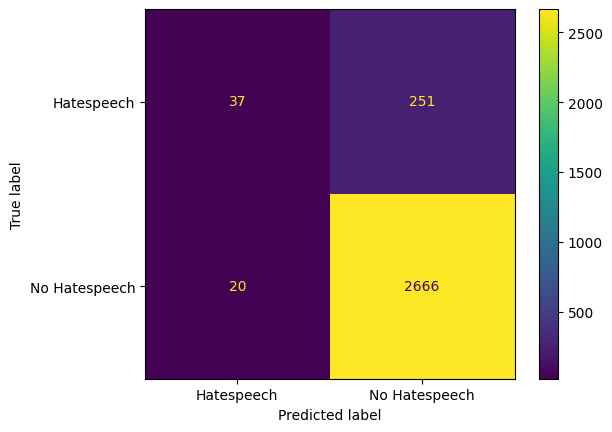

Epochs: 7 | Loss:  0.008 | Accuracy:  0.912 | Test Loss:  0.008 | Test Accuracy:  0.909
[0.0097740976451179, 0.009072536609192562, 0.008709740098164978, 0.008445817415703341, 0.008035595980663886, 0.0078052374746941065, 0.007635091933426175] [[0.009475622784594361], [0.009086767335565762], [0.008666753849088545], [0.008412682414355499], [0.008449436862475132], [0.008239923368215], [0.008251799658822709]]


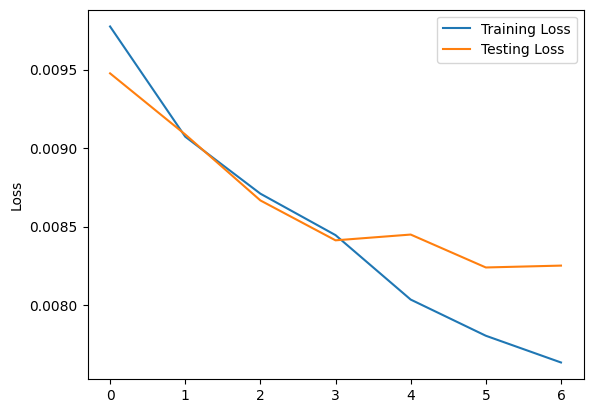

~~~~~~~~~~~~~~~~~~~~~~~~~~
Training for fold 4


100%|██████████| 93/93 [00:06<00:00, 14.43it/s]


Epochs: 1 | Loss:  0.010 | Accuracy:  0.902 | Test Loss:  0.010 | Test Accuracy:  0.881


100%|██████████| 93/93 [00:06<00:00, 14.59it/s]


Epochs: 2 | Loss:  0.009 | Accuracy:  0.908 | Test Loss:  0.009 | Test Accuracy:  0.908


100%|██████████| 93/93 [00:06<00:00, 13.84it/s]


Epochs: 3 | Loss:  0.008 | Accuracy:  0.908 | Test Loss:  0.009 | Test Accuracy:  0.908


100%|██████████| 93/93 [00:06<00:00, 14.45it/s]


Epochs: 4 | Loss:  0.008 | Accuracy:  0.910 | Test Loss:  0.009 | Test Accuracy:  0.900


100%|██████████| 93/93 [00:05<00:00, 16.20it/s]


Epochs: 5 | Loss:  0.008 | Accuracy:  0.909 | Test Loss:  0.009 | Test Accuracy:  0.903


100%|██████████| 93/93 [00:05<00:00, 15.96it/s]


Epochs: 6 | Loss:  0.008 | Accuracy:  0.910 | Test Loss:  0.008 | Test Accuracy:  0.903


100%|██████████| 93/93 [00:05<00:00, 15.71it/s]

              precision    recall  f1-score   support

           0       0.59      0.32      0.42       299
           1       0.93      0.97      0.95      2675

    accuracy                           0.91      2974
   macro avg       0.76      0.65      0.68      2974
weighted avg       0.89      0.91      0.90      2974



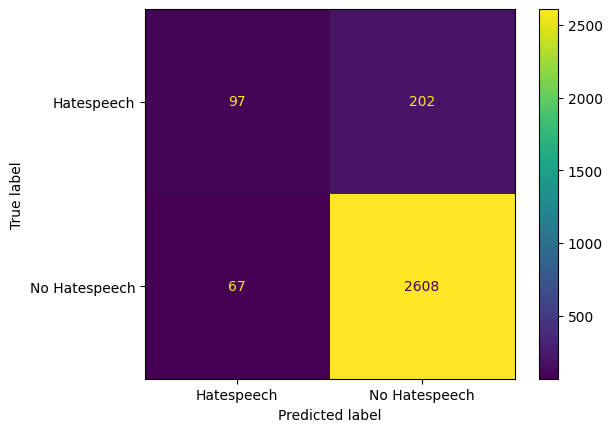

Epochs: 7 | Loss:  0.008 | Accuracy:  0.912 | Test Loss:  0.008 | Test Accuracy:  0.910
[0.009720233029159187, 0.008640446842954355, 0.008311429619663862, 0.008070757092435788, 0.008068893145188619, 0.007926497504455817, 0.007653024208574746] [[0.009979618817227113], [0.00853045855441507], [0.0087243374775301], [0.008737589211955357], [0.008733417099766388], [0.008424688093038557], [0.008157664251081]]


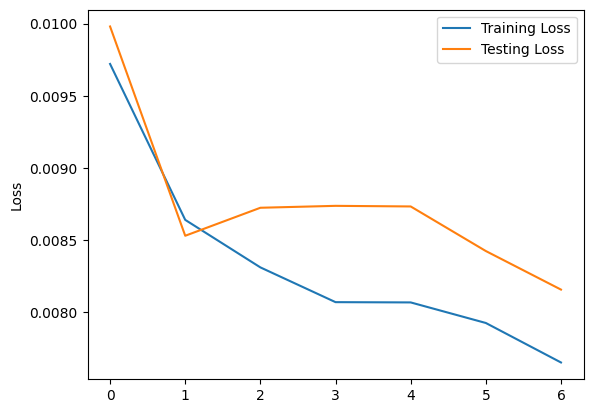

~~~~~~~~~~~~~~~~~~~~~~~~~~
Training for fold 5


100%|██████████| 93/93 [00:05<00:00, 16.17it/s]


Epochs: 1 | Loss:  0.010 | Accuracy:  0.900 | Test Loss:  0.009 | Test Accuracy:  0.903


100%|██████████| 93/93 [00:06<00:00, 15.08it/s]


Epochs: 2 | Loss:  0.009 | Accuracy:  0.907 | Test Loss:  0.009 | Test Accuracy:  0.905


100%|██████████| 93/93 [00:06<00:00, 14.54it/s]


Epochs: 3 | Loss:  0.008 | Accuracy:  0.909 | Test Loss:  0.009 | Test Accuracy:  0.903


100%|██████████| 93/93 [00:06<00:00, 15.18it/s]


Epochs: 4 | Loss:  0.008 | Accuracy:  0.911 | Test Loss:  0.009 | Test Accuracy:  0.903


100%|██████████| 93/93 [00:06<00:00, 15.12it/s]


Epochs: 5 | Loss:  0.008 | Accuracy:  0.909 | Test Loss:  0.008 | Test Accuracy:  0.905


100%|██████████| 93/93 [00:06<00:00, 15.46it/s]


Epochs: 6 | Loss:  0.008 | Accuracy:  0.911 | Test Loss:  0.009 | Test Accuracy:  0.904


100%|██████████| 93/93 [00:05<00:00, 16.14it/s]


              precision    recall  f1-score   support

           0       0.49      0.19      0.28       295
           1       0.92      0.98      0.95      2679

    accuracy                           0.90      2974
   macro avg       0.70      0.59      0.61      2974
weighted avg       0.87      0.90      0.88      2974



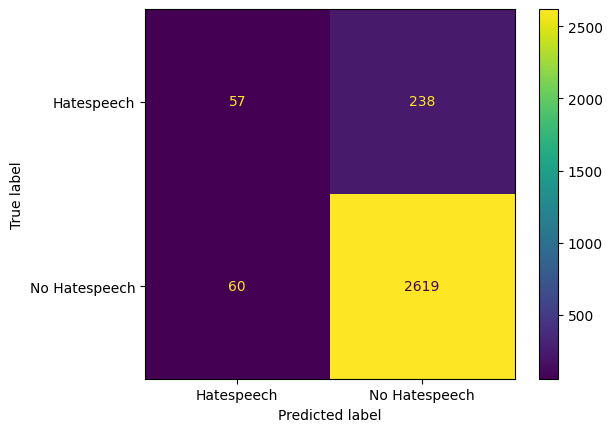

Epochs: 7 | Loss:  0.008 | Accuracy:  0.911 | Test Loss:  0.009 | Test Accuracy:  0.900
[0.009611492378107336, 0.00856065177690631, 0.008140878227026412, 0.008045366950829155, 0.007874530838412892, 0.0077079524462710675, 0.0076066111206630075] [[0.009010248010190205], [0.008611546627671107], [0.00851377950281045], [0.008746677528623374], [0.00844514691637279], [0.009478376784988835], [0.008625634975365608]]


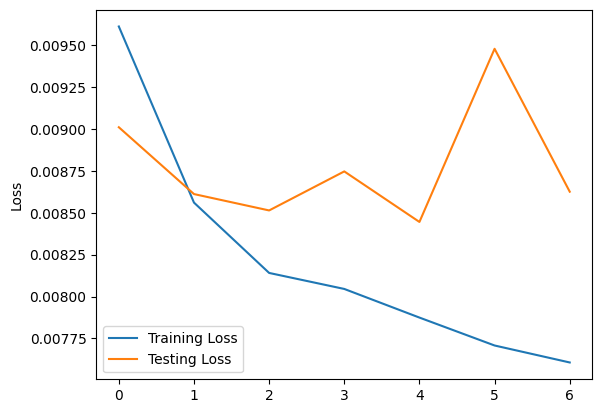

In [127]:
from sklearn.model_selection import KFold, cross_val_score 

model = TransformerEncoderModel(len(vocab), d_model=300, nhead=4, d_ff=50, 
                                    N=6, dropout=0.1).to(device)

epochs = 7
lr = 1e-4
batch_size = 32

k_folds = KFold(n_splits=5, shuffle=True)

fold_no = 1
for train1, test in k_folds.split(tweets_df['tweet'],tweets_df['class']):
    model = TransformerEncoderModel(len(vocab), d_model=300, nhead=4, d_ff=50, 
                                    N=6, dropout=0.1).to(device)

    train_input = tweets_df.iloc[train1]
    test_input = tweets_df.iloc[test]
    
    train_classes = tweets_df['class'].iloc[train1]

    print("~~~~~~~~~~~~~~~~~~~~~~~~~~")
    print(f"Training for fold {fold_no}")
    # epochs = 30
    # lr = 1e-4
    # batch_size = 4
    fold_train_losses, fold_train_accs, fold_test_losses, fold_test_accs  = train(model, train_input, test_input, epochs, lr, batch_size)
    # train_losses, train_accuracies, test_loss, test_acc
    # print(f'Fold training loss {fold_losses[-1]}, training accuracy {fold_accuracies[-1]}')
    print(fold_train_losses, fold_test_losses)
    plt.plot(fold_train_losses)
    plt.plot(fold_test_losses)
    plt.legend(['Training Loss', 'Testing Loss'])
    plt.ylabel('Loss')
    plt.show()
    # print(f'Fold Testing Accuracy {testing_accuracy}')
    fold_no = fold_no + 1


### Hard coded values of fold training accuracy and f1 scores

I forgot to automatically calculate this in the training loop :(

In [128]:
# fold_average_training_loss = (0.083 + 0.099 + 0.081 + 0.083 + 0.082) / 5
# fold_average_training_accuracy = (0.911 + 0.904 + 0.913 + 0.911 + 0.913) / 5
fold_average_testing_accuracy = sum([0.91, 0.91, 0.91, 0.91, 0.9]) / 5
fold_average_testing_f1_score = sum([0.29, 0.26, 0.21, 0.42, 0.28]) / 5

# print("Average fold training accuracy: ", fold_average_training_accuracy)
# print("Average fold training loss: ", fold_average_training_loss)
print("Average fold testing accuracy: ", fold_average_testing_accuracy)
print("Average fold f1-score: ", fold_average_testing_f1_score)

# fold_average_training_loss = ( 0.079 + 0.081 + 0.082 + 0.099 + 0.083) / 5
# fold_average_training_accuracy = (0.911 + 0.913 + 0.910 + 0.911 + 0.903) / 5
# fold_average_testing_accuracy = (0.8856758574310692 + 0.9088769334229994 + 0.8839946200403497 + 0.8974445191661062 + 0.9088769334229994) / 5

# print("\nAverage fold training accuracy: ", fold_average_training_accuracy)
# print("Average fold training loss: ", fold_average_training_loss)
# print("Average fold testing accuracy: ", fold_average_testing_accuracy)

Average fold testing accuracy:  0.908
Average fold f1-score:  0.292
